In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


# --- Problem setup ---
N = 100          # number of time steps
T = 5.0
dt = T / N

n_x = 2          # state dimension
n_u = 1          # control dimension

A = np.array([[0.0, -1.0],
              [1.0, 0.0]])

B = np.array([[0.0],
              [1.0]])

# Initial value
x_iv = np.array([2.0, -1.0])    # example initial condition

# Unknowns: (x_0,...,x_N, u_1,...,u_N)
num_x_vars = (N + 1) * n_x
num_u_vars = N * n_u
num_vars   = num_x_vars + num_u_vars

# Equations: initial condition (n_x) + N state steps (N*n_x)
num_eqs = n_x + N * n_x

# Operator matrix and RHS
C = np.zeros((num_eqs, num_vars))
rhs = np.zeros(num_eqs)

I = np.eye(n_x)

# 1. Initial condition row block
row0_start, row0_end = 0, n_x
C[row0_start:row0_end, 0:n_x] = I
rhs[row0_start:row0_end] = x_iv

# 2. Implicit Euler dynamics
for k in range(1, N + 1):
    row_start = n_x + (k - 1) * n_x
    row_end   = row_start + n_x

    col_xkm1_start = (k - 1) * n_x
    col_xkm1_end   = col_xkm1_start + n_x

    col_xk_start   = k * n_x
    col_xk_end     = col_xk_start + n_x

    col_uk_start = num_x_vars + (k - 1) * n_u
    col_uk_end   = col_uk_start + n_u

    C[row_start:row_end, col_xk_start:col_xk_end]     += (1.0 / dt) * I - A
    C[row_start:row_end, col_xkm1_start:col_xkm1_end] += -(1.0 / dt) * I
    C[row_start:row_end, col_uk_start:col_uk_end]     += -B


def w(r):
    return 1 + r**2   # example; you may choose any smooth function

def f_conservative(x):
    x1, x2 = x
    r = np.sqrt(x1**2 + x2**2)
    omega = w(r)
    return np.array([
        -omega * x2,
         omega * x1
    ])



def constrained_rhs_coupled(t, y, M, B_p, H, C, B, n_x, delta, c, alpha): # coupled optimizer-plant dynamics (including inequality constraints)
    n_p = M.shape[0]      # dimension of x_p
    n_z = num_x_vars      #H.shape[0]      # dimension of z
    n_eq = C.shape[0]     # number of constraints (IC + dynamics)
    assert n_eq == n_x + (n_eq - n_x)  # sanity

    # Unpack state
    x_p = y[:n_p]
    x   = y[n_p:n_p + n_z]
    ell = y[n_p + n_z:]             # (lambda_0, lambda_dyn)

    # Split ell into lambda_0 and lambda_dyn
    ell_IC  = ell[:n_x]             # lambda_0
    ell_dyn = ell[n_x:]             # lambda over time grid

    # 1) Plant dynamics: u_p = B^T lambda_0
    u_p = np.clip((1 / alpha) * B.T @ ell_IC, -c, c) - np.clip(B_p.T @ x_p, -c, c)        # shape (n_u,)
    u_p = 1/2 * u_p 
    x_p_dot = f_conservative(x_p) + B_p @ u_p #M @ x_p + B_p @ u_p 

    # 2) Primal dynamics for z (can be customized)
    CTell_copy = C.T @ ell
    x_dot = delta * (- x - CTell_copy[:num_x_vars])

    # 3) Dual dynamics (lambda, lambda_0)
    r = C @ np.concatenate([x,-np.clip(CTell_copy[num_x_vars:], -c, c)])                        # r = C(x,u)
    r_IC  = r[:n_x]
    r_dyn = r[n_x:]

    # lambda_0_dot = B B^T x_p - r_IC
    ell_IC_dot  = delta * (r_IC - (1 / alpha) * B @ u_p)  #x(0) - BB_p^T x_p(t)

    # lambda_dyn_dot = - r_dyn
    ell_dyn_dot = delta * r_dyn 

    ell_dot = np.concatenate([ell_IC_dot, ell_dyn_dot])

    # Stack everything back
    dydt = np.concatenate([x_p_dot, x_dot, ell_dot])
    return dydt


def reduced_rhs_coupled(t, y, M, B_p, H, C, B, n_x, delta, alpha): #coupled optimizer-plant dynamics (unconstrained case)
    n_p = M.shape[0]      # dimension of x_p
    n_z = num_x_vars      #H.shape[0]      # dimension of z
    n_eq = C.shape[0]     # number of constraints (IC + dynamics)
    assert n_eq == n_x + (n_eq - n_x)  # sanity

    # Unpack state
    x_p = y[:n_p]
    x   = y[n_p:n_p + n_z]
    ell = y[n_p + n_z:]             # (lambda_0, lambda_dyn)

    # Split ell into lambda_0 and lambda_dyn
    ell_IC  = ell[:n_x]             # lambda_0
    ell_dyn = ell[n_x:]             # lambda over time grid

    # 1) Plant dynamics: u_p = B^T lambda_0
    u_p = (1 / alpha) * B.T @ ell_IC      # shape (n_u,)
    x_p_dot = f_conservative(x_p) + B_p @ u_p #M @ x_p + B_p @ u_p 

    # 2) Primal dynamics for z (can be customized)
    x_dot = delta * (- x - (C.T @ ell)[:num_x_vars])

    # 3) Dual dynamics (lambda, lambda_0)
    r = C @ np.concatenate([x,-(1 / alpha) * (C.T @ ell)[num_x_vars:]])                        # r = C(x,u)
    r_IC  = r[:n_x]
    r_dyn = r[n_x:]

    # lambda_0_dot = B B^T x_p - r_IC
    ell_IC_dot  = delta * (r_IC - (1 / alpha) * B @ B_p.T @ x_p)  #x(0) - BB_p^T x_p(t)

    # lambda_dyn_dot = - r_dyn
    ell_dyn_dot = delta * r_dyn 

    ell_dot = np.concatenate([ell_IC_dot, ell_dyn_dot])

    # Stack everything back
    dydt = np.concatenate([x_p_dot, x_dot, ell_dot])
    return dydt

def clipped_reduced_rhs_coupled(t, y, M, B_p, H, C, B, n_x, c, delta, alpha):
    n_p = M.shape[0]      # dimension of x_p
    n_z = num_x_vars      #H.shape[0]      # dimension of z
    n_eq = C.shape[0]     # number of constraints (IC + dynamics)
    assert n_eq == n_x + (n_eq - n_x)  # sanity

    # Unpack state
    x_p = y[:n_p]
    x   = y[n_p:n_p + n_z]
    ell = y[n_p + n_z:]             # (lambda_0, lambda_dyn)

    # Split ell into lambda_0 and lambda_dyn
    ell_IC  = ell[:n_x]             # lambda_0
    ell_dyn = ell[n_x:]             # lambda over time grid

    # 1) Plant dynamics: u_p = B^T lambda_0
    u_p = (1 / alpha) * B.T @ ell_IC      # shape (n_u,)
    x_p_dot = f_conservative(x_p) + B_p @ np.clip(u_p, -c, c) #M @ x_p + B_p @ u_p 

    # 2) Primal dynamics for z (can be customized)
    x_dot = delta * (- x - (C.T @ ell)[:num_x_vars])

    # 3) Dual dynamics (lambda, lambda_0)
    r = C @ np.concatenate([x,-(1 / alpha) * (C.T @ ell)[num_x_vars:]])                        # r = C(x,u)
    r_IC  = r[:n_x]
    r_dyn = r[n_x:]

    # lambda_0_dot = B B^T x_p - r_IC
    ell_IC_dot  = delta * (r_IC - B @ np.clip((1 / alpha) * B_p.T @ x_p, -c, c))  #x(0) - BB_p^T x_p(t)

    # lambda_dyn_dot = - r_dyn
    ell_dyn_dot = delta * r_dyn 

    ell_dot = np.concatenate([ell_IC_dot, ell_dyn_dot])

    # Stack everything back
    dydt = np.concatenate([x_p_dot, x_dot, ell_dot])
    return dydt


def rhs_coupled_with_lambda0(t, y, M, B_p, H, C, B, n_x, delta, alpha):
    # Dimensions
    n_p = M.shape[0]      # dimension of x_p
    n_z = H.shape[0]      # dimension of z
    n_eq = C.shape[0]     # number of constraints (IC + dynamics)
    assert n_eq == n_x + (n_eq - n_x)  # sanity

    # Unpack state
    x_p = y[:n_p]
    z   = y[n_p:n_p + n_z]
    ell = y[n_p + n_z:]              # (lambda_0, lambda_dyn)

    # Split ell into lambda_0 and lambda_dyn
    ell_IC  = ell[:n_x]             # lambda_0
    ell_dyn = ell[n_x:]             # lambda over time grid

    # 1) Plant dynamics: u_p = B^T lambda_0
    u_p =  (1/alpha) *  B.T @ ell_IC      # shape (n_u,)
    x_p_dot = f_conservative(x_p) +  B_p @ u_p

    # 2) Primal dynamics for z (can be customized)
    z_dot = delta * (- H @ z - C.T @ ell)

    # 3) Dual dynamics (lambda, lambda_0)
    r = C @ z                        # r = C(x,u)
    r_IC  = r[:n_x]                  # x(0)
    r_dyn = r[n_x:]                  # (d/dt - A)x  - Bu

    # lambda_0_dot = B B^T x_p - r_IC
    ell_IC_dot  = delta * (r_IC - (1/alpha) * B @ (B_p.T @ x_p))       # x(0) - 1/alpha * BB_p^T x_p

    # lambda_dyn_dot = - r_dyn
    ell_dyn_dot = delta * r_dyn

    ell_dot = np.concatenate([ell_IC_dot, ell_dyn_dot])

    # Stack everything back
    dydt = np.concatenate([x_p_dot, z_dot, ell_dot])
    return dydt


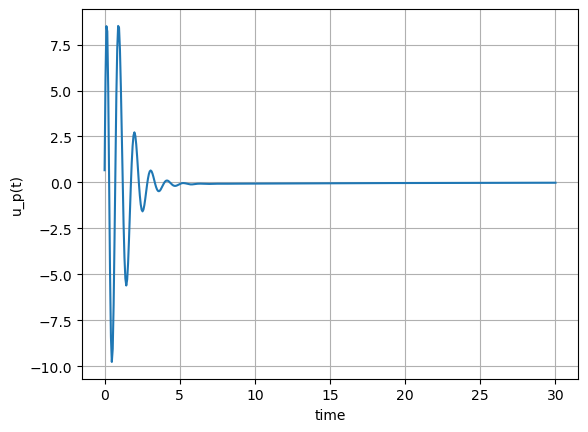

u_p at final time: -0.015079402841496788


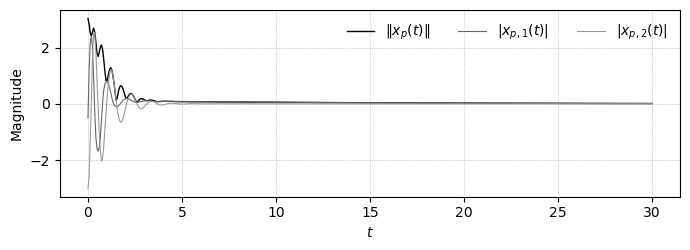

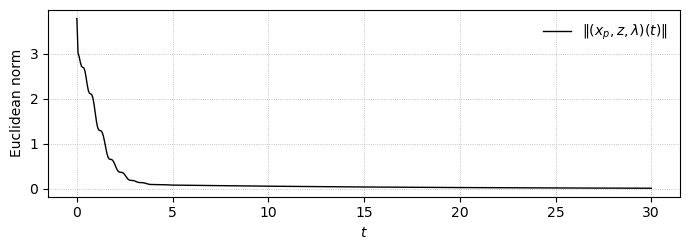

In [3]:
### examples without inequality constraints

# --- Plant matrices M, B_p (same shapes as A, B) ---
# You can choose them independently; here, just as an example:
M = A #np.array([[0.0,  -1.0],
    #          [1.0, 0.0]])      # 2x2, same shape as A

B_p = B #np.array([[0.0],
      #          [1.0]])           # 2x1, same shape as B

# --- Hessian H for a quadratic cost J(z) = 1/2 sum ||x_k||^2 + (alpha/2) sum ||u_k||^2 ---


alpha = 1.5


# Weights on diagonal: 1 for all state components, alpha for all control components
weights = np.concatenate([
    np.ones(num_x_vars),           # x-part
    alpha * np.ones(num_u_vars)    # u-part
])

H = np.diag(weights)  # H is num_vars x num_vars, block-diagonal

# Dimensions
n_p = M.shape[0]
n_z = H.shape[0]
n_eq = C.shape[0]
n_x  = B.shape[0]          # state dimension (e.g. 2)

# Initial conditions
x_p0  = np.array([-0.5, -3.0]) #4 * np.ones(n_p) 
z0    = np.ones(num_x_vars)       #np.zeros(n_z)
ell0  = np.ones(n_eq)     # (lambda_0, lambda_dyn)

y0 = np.concatenate([x_p0, z0, ell0])

t_span = (0.0, 30.0)
t_eval = np.linspace(t_span[0], t_span[1], 500)
delta = 80.0


sol = solve_ivp(
    fun=reduced_rhs_coupled,#rhs_coupled_with_lambda0,
    t_span=t_span,
    y0=y0,
    t_eval=t_eval,
    args=(M, B_p, H, C, B, n_x, delta, alpha)
)


# Extract solution
Y = sol.y    # shape (n_p + n_z + n_eq, N)
times = sol.t


n_p = M.shape[0]
n_z = num_x_vars
n_eq = C.shape[0]

# Unpack from stacked state over all time
x_p_traj = Y[:n_p, :]               # shape (n_p, N)
x_traj   = Y[n_p:n_p + n_z, :]      # not needed for u_p
ell_traj = Y[n_p + n_z:, :]         # shape (n_eq, N)

ell_IC_traj  = ell_traj[:n_x, :]    # λ0(t), shape (n_x, N)

# Compute u_p(t) for all time steps
u_p_traj = (1/alpha) * B.T @ ell_IC_traj
plt.figure()
plt.plot(times, u_p_traj[0, :])
plt.xlabel("time")
plt.ylabel("u_p(t)")
plt.grid(True)
plt.show()

# Plant states
#x_p = Y[:n_p, :]           # shape (2, T)
x_p1 = x_p_traj[0, :]
x_p2 = x_p_traj[1, :]

abs_x_p1 = np.abs(x_p1)
abs_x_p2 = np.abs(x_p2)

# Full-state norm
# full_norm = np.linalg.norm(Y, axis=0)

# Option 1: scale second component by 1/sqrt(delta) and use usual norm
Y_scaled = Y.copy()
Y_scaled[2:, :] *= 1 / np.sqrt(delta)   # only modify the second component

norm_delta = np.linalg.norm(Y_scaled, axis=0)   # ||Y||_delta at each time


# If you specifically want the squared norm:
norm_delta_sq = norm_delta**2


# Or print some values
print("u_p at final time:", u_p_traj[0, -1])


# ==================================================================
# FIGURE 4: Plant state components
# ==================================================================
fig4, ax4 = plt.subplots(figsize=(7.0, 2.6))

ax4.plot(
    times,
    np.linalg.norm(x_p_traj, axis=0),
    linewidth=1.0,
    color="black",
    label=r"$\|x_p(t)\|$"
)

ax4.plot(
    times,
    x_p1,
    linewidth=0.8,
    color="0.4",
    label=r"$|x_{p,1}(t)|$"
)

ax4.plot(
    times,
    x_p2,
    linewidth=0.8,
    color="0.6",
    label=r"$|x_{p,2}(t)|$"
)

ax4.set_xlabel(r"$t$")
ax4.set_ylabel(r"Magnitude")

ax4.grid(
    True,
    linestyle=":",
    linewidth=0.6,
    color="0.7"
)

ax4.legend(frameon=False, ncols=3)
fig4.tight_layout()
plt.show()

# ==================================================================
# FIGURE 5: Norm of coupled state (x_p, z, lambda)
# ==================================================================
fig5, ax5 = plt.subplots(figsize=(7.0, 2.6))

ax5.plot(
    times,
    norm_delta,
    linewidth=1.0,
    color="black",
    label=r"$\|(x_p,z,\lambda)(t)\|$"
)

ax5.set_xlabel(r"$t$")
ax5.set_ylabel(r"Euclidean norm")

ax5.grid(
    True,
    linestyle=":",
    linewidth=0.6,
    color="0.7"
)

ax5.legend(frameon=False)
fig5.tight_layout()
plt.show()


(404, 500)


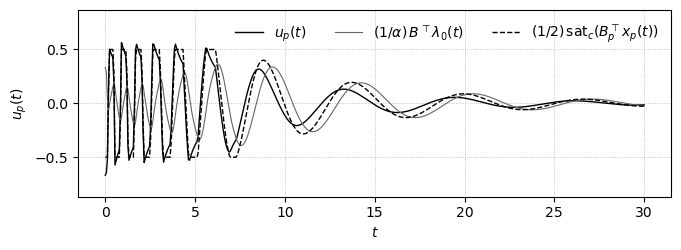

u_p at final time: -0.014096442675160624


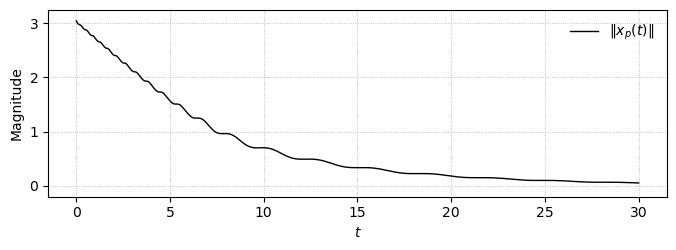

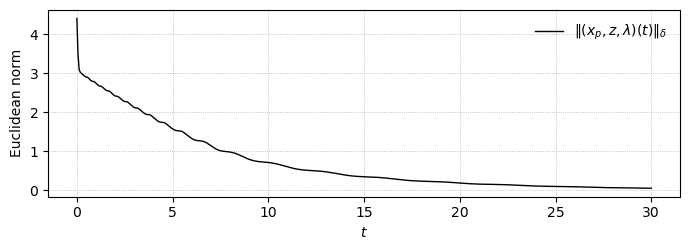

In [5]:
### examples with inequality constraints
# --- Plant matrices M, B_p (same shapes as A, B) ---
# You can choose them independently; here, just as an example:
M = A #np.array([[0.0,  -1.0],
    #          [1.0, 0.0]])      # 2x2, same shape as A

B_p = B #np.array([[0.0],
      #          [1.0]])           # 2x1, same shape as B

alpha = 3.0

# Weights on diagonal: 1 for all state components, alpha for all control components
weights = np.concatenate([
    np.ones(num_x_vars),           # x-part
    alpha * np.ones(num_u_vars)    # u-part
])

H = np.diag(weights)  # H is num_vars x num_vars, block-diagonal


# Dimensions
n_p = M.shape[0]
n_z = num_x_vars #H.shape[0]
n_eq = C.shape[0]
n_x  = B.shape[0]          # state dimension (e.g. 2)

# Initial conditions
#a, b = -1.0, 1.0
#x_p0 = a + (b - a) * np.random.rand(2)
#x_p0 = 10 * x_p0
#print(x_p0)
x_p0  = np.array([-0.5, -3.0]) #4 * np.ones(n_p) 
z0    = np.zeros(n_z)
ell0  = np.ones(n_eq)     # (lambda_0, lambda_dyn)

y0 = np.concatenate([x_p0, z0, ell0])

t_span = (0.0, 30.0)
t_eval = np.linspace(t_span[0], t_span[1], 500)
delta = 20
c = 1.0

sol = solve_ivp(
    fun=constrained_rhs_coupled, #rhs_coupled_with_lambda0,
    t_span=t_span,
    y0=y0,
    t_eval=t_eval,
    args=(M, B_p, H, C, B, n_x, delta, c, alpha)
)
# Extract solution
Y = sol.y    # shape (n_p + n_z + n_eq, N)
times = sol.t
print(np.shape(Y[2:, :]))

n_p = M.shape[0]
n_z = num_x_vars
n_eq = C.shape[0]

# Unpack from stacked state over all time
x_p_traj_constr = Y[:n_p, :]               # shape (n_p, N)
x_traj   = Y[n_p:n_p + n_z, :]      # not needed for u_p
ell_traj = Y[n_p + n_z:, :]         # shape (n_eq, N)

ell_IC_traj  = ell_traj[:n_x, :]    # λ0(t), shape (n_x, N)

# Compute u_p(t) for all time steps
u_p_traj_new = (
    np.clip((1 / alpha) * B.T @ ell_IC_traj, -c,c) -      # B^T λ0
    np.clip(B_p.T @ x_p_traj_constr, -c, c)         # B_p^T x_p
)
u_p_traj_new *= -0.5   # apply 1/2 factor


# Plant states
#x_p = Y[:n_p, :]           # shape (2, T)
x_p1 = x_p_traj_constr[0, :]
x_p2 = x_p_traj_constr[1, :]

abs_x_p1 = np.abs(x_p1)
abs_x_p2 = np.abs(x_p2)

# Full-state norm
# full_norm = np.linalg.norm(Y, axis=0)

# Option 1: scale second component by 1/sqrt(delta) and use usual norm
Y_scaled = Y.copy()
Y_scaled[2:, :] *= 1 / np.sqrt(delta)   # only modify the second component

norm_delta_new = np.linalg.norm(Y_scaled, axis=0)   # ||Y||_delta at each time
# ==================================================================
# Journal-style plotting (TAC / double-column)
# ==================================================================

# --- Figure-wide common limits (optional but recommended) ---
m = 0.2
y_u = np.max(np.abs(u_p_traj_new[0, :]))
y_x = np.max(np.linalg.norm(x_p_traj_constr, axis=0))
y_y = np.max(norm_delta_new)

# ==================================================================
# FIGURE 1: Control decomposition
# u_p(t), (1/alpha) B^T ell_IC, (1/2) sat(B_p^T x_p)
# ==================================================================
fig1, ax1 = plt.subplots(figsize=(7.0, 2.6))

ax1.plot(
    times, u_p_traj_new[0, :],
    linewidth=1.0,
    color="black",
    label=r"$u_p(t)$"
)
ax1.plot(
    times, ((1/alpha) * (B.T @ ell_IC_traj))[0, :],
    linewidth=0.8,
    color="0.4",
    label=r"$(1/\alpha)\,B^\top \lambda_0(t)$"
)

ax1.plot(
    times, 0.5 * np.clip((B_p.T @ x_p_traj_constr), -c, c)[0, :],
    linestyle="--",
    linewidth=1.0,
    color="black",
    label=r"$(1/2)\,\mathrm{sat}_c(B_p^\top x_p(t))$"
)
ax1.set_xlabel(r"$t$")
ax1.set_ylabel(r"$u_p(t)$")

ax1.grid(True, which="both", linestyle=":", linewidth=0.6, color="0.7")
ax1.legend(frameon=False, ncols=3, loc="best")

# Optional: symmetric y-limits for control plots
ax1.set_ylim(-(y_u + m), y_u + m)

fig1.tight_layout()
plt.show()

print("u_p at final time:", u_p_traj_new[0, -1])

# ==================================================================
# FIGURE 2: Plant state norm (and optionally components)
# ==================================================================
fig2, ax2 = plt.subplots(figsize=(7.0, 2.6))

ax2.plot(
    times, np.linalg.norm(x_p_traj_constr, axis=0),
    linewidth=1.0,
    color="black",
    label=r"$\|x_p(t)\|$"
)

# If you want component magnitudes as well (commented in your original):
# ax2.plot(times, np.abs(x_p1), linewidth=0.8, color="0.4", label=r"$|x_{p,1}(t)|$")
# ax2.plot(times, np.abs(x_p2), linewidth=0.8, color="0.6", label=r"$|x_{p,2}(t)|$")

ax2.set_xlabel(r"$t$")
ax2.set_ylabel(r"Magnitude")

ax2.grid(True, which="both", linestyle=":", linewidth=0.6, color="0.7")
ax2.legend(frameon=False, loc="best")

ax2.set_ylim(-m, y_x + m)

fig2.tight_layout()
plt.show()

# ==================================================================
# FIGURE 3: Weighted coupled-state norm  ||Y||_delta
# ==================================================================
fig3, ax3 = plt.subplots(figsize=(7.0, 2.6))

ax3.plot(
    times, norm_delta_new,
    linewidth=1.0,
    color="black",
    label=r"$\| (x_p,z,\lambda)(t) \|_{\delta}$"
)

ax3.set_xlabel(r"$t$")
ax3.set_ylabel(r"Euclidean norm")

ax3.grid(True, which="both", linestyle=":", linewidth=0.6, color="0.7")
ax3.legend(frameon=False, loc="best")


fig3.tight_layout()
plt.show()


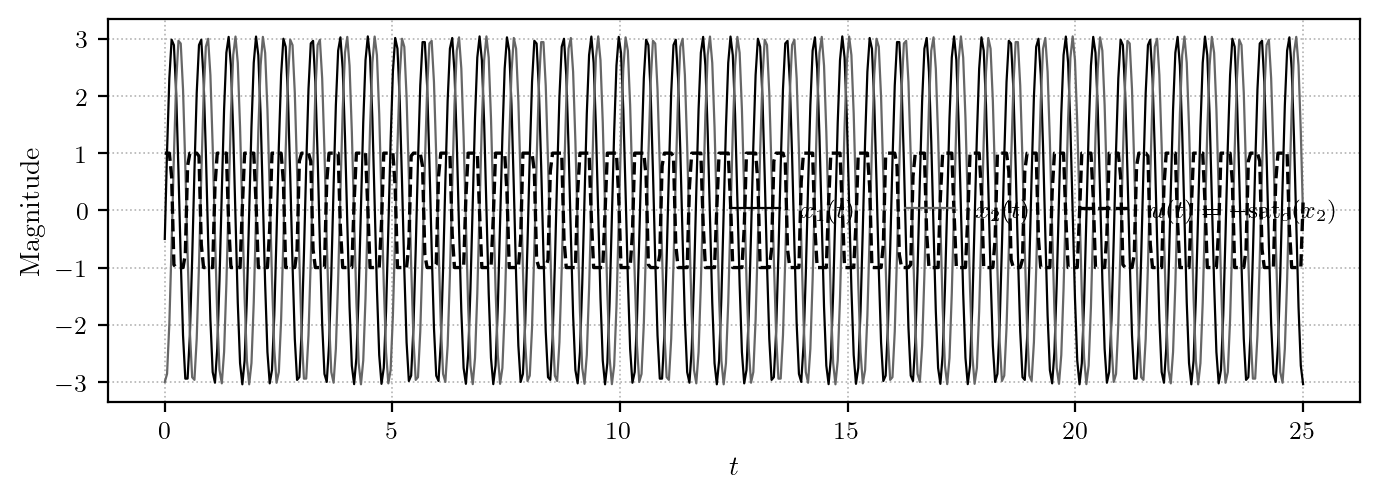

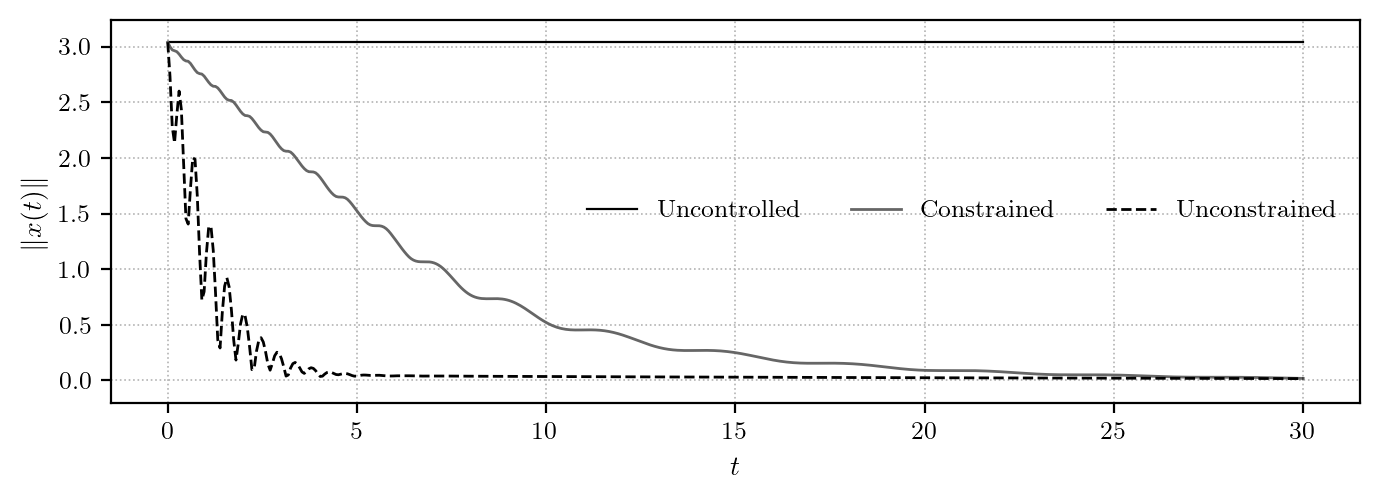

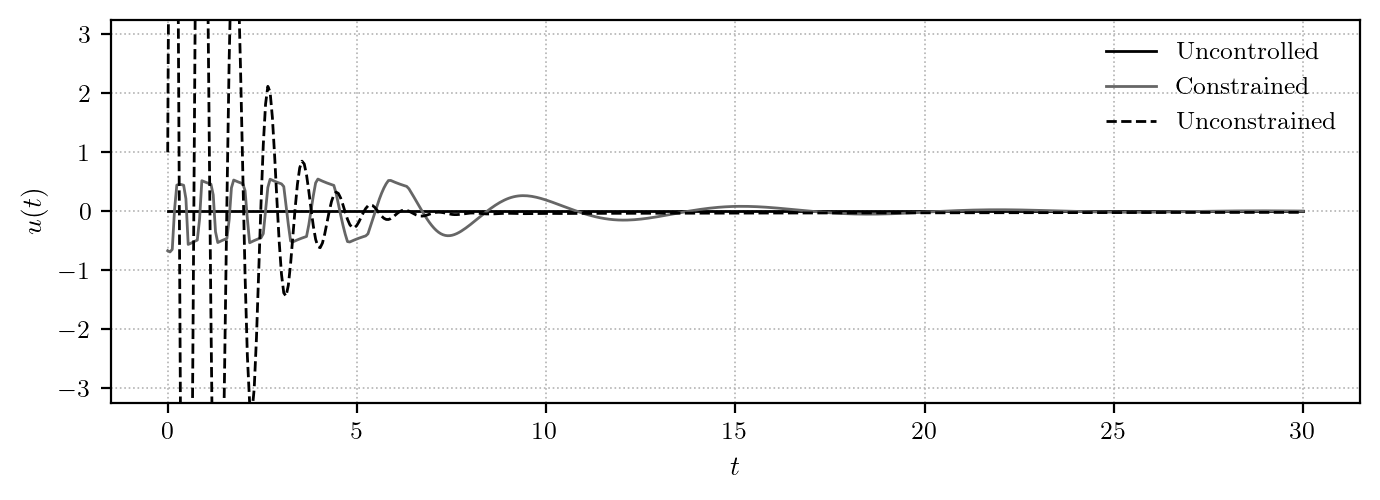

In [165]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# ------------------------------------------------------------------
# Journal-style defaults (LaTeX + serif + consistent sizing)
# ------------------------------------------------------------------
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

# ------------------------------------------------------------------
# Conservative vector field
# ------------------------------------------------------------------
def w(r):
    return 1.0 + r**2

def f_conservative_ode(t, x):
    x1, x2 = x
    r = np.sqrt(x1**2 + x2**2)
    omega = w(r)
    return np.array([
        -omega * x2,
         omega * x1
    ])

# ------------------------------------------------------------------
# Simulation
# ------------------------------------------------------------------
t_span = (0.0, 25.0)
t_eval = np.linspace(*t_span, 500)
x0 = np.array([-0.5, -3.0])

sol = solve_ivp(
    f_conservative_ode,
    t_span,
    x0,
    t_eval=t_eval,
    rtol=1e-8,
    atol=1e-10
)

t = sol.t
x1, x2 = sol.y
norm_full = np.sqrt(x1**2 + x2**2)

# Saturation parameter
c = 1.0
u = -np.clip(x2, -c, c)

# Common y-limits
m = 0.2
y_max = np.max(norm_full)

# ==================================================================
# FIGURE 1: State trajectories and control
# ==================================================================
fig1, ax1 = plt.subplots(figsize=(7.0, 2.6))

ax1.plot(t, x1, linewidth=0.8, color="black", label=r"$x_1(t)$")
ax1.plot(t, x2, linewidth=0.8, color="0.4", label=r"$x_2(t)$")
ax1.plot(
    t, u,
    linestyle="--",
    linewidth=1.2,
    color="black",
    label=r"$u(t)=-\mathrm{sat}_c(x_2)$"
)

ax1.set_xlabel(r"$t$")
ax1.set_ylabel(r"Magnitude")
ax1.grid(True, linestyle=":", linewidth=0.6, color="0.7")
ax1.legend(frameon=False, ncols=3)
fig1.tight_layout()
plt.show()

# ==================================================================
# FIGURE 2: State norm comparison
# (uncontrolled / constrained / unconstrained)
# ==================================================================
# Assumed externally defined:
# times, x_p_traj, x_p_traj_constr

fig2, ax2 = plt.subplots(figsize=(7.0, 2.6))

ax2.plot(
    times,
    norm_full[0] * np.ones_like(times),
    linewidth=0.8,
    color="black",
    label="Uncontrolled"
)

ax2.plot(
    times,
    np.linalg.norm(x_p_traj_constr, axis=0),
    linewidth=1.0,
    color="0.4",
    label="Constrained"
)

ax2.plot(
    times,
    np.linalg.norm(x_p_traj, axis=0),
    linestyle="--",
    linewidth=1.0,
    color="black",
    label="Unconstrained"
)

ax2.set_xlabel(r"$t$")
ax2.set_ylabel(r"$\|x(t)\|$")
ax2.set_ylim(-m, y_max + m)
ax2.grid(True, linestyle=":", linewidth=0.6, color="0.7")
ax2.legend(frameon=False, ncols=3)
fig2.tight_layout()
plt.show()

# ==================================================================
# FIGURE 3: Control comparison
# ==================================================================
# Assumed externally defined:
# u_p_traj, u_p_traj_new

fig3, ax3 = plt.subplots(figsize=(7.0, 2.6))

ax3.plot(
    times,
    0*u_p_traj_new[0, :],
    linewidth=1.0,
    color="black",
    label="Uncontrolled"
)

ax3.plot(
    times,
    u_p_traj_new[0, :],
    linewidth=1.0,
    color="0.4",
    label="Constrained"
)

ax3.plot(
    times,
    u_p_traj[0, :],
    linestyle="--",
    linewidth=1.0,
    color="black",
    label="Unconstrained"
)

ax3.set_xlabel(r"$t$")
ax3.set_ylabel(r"$u(t)$")
ax3.set_ylim(-y_max - m, y_max + m)
ax3.grid(True, linestyle=":", linewidth=0.6, color="0.7")
ax3.legend(frameon=False)
fig3.tight_layout()
plt.show()


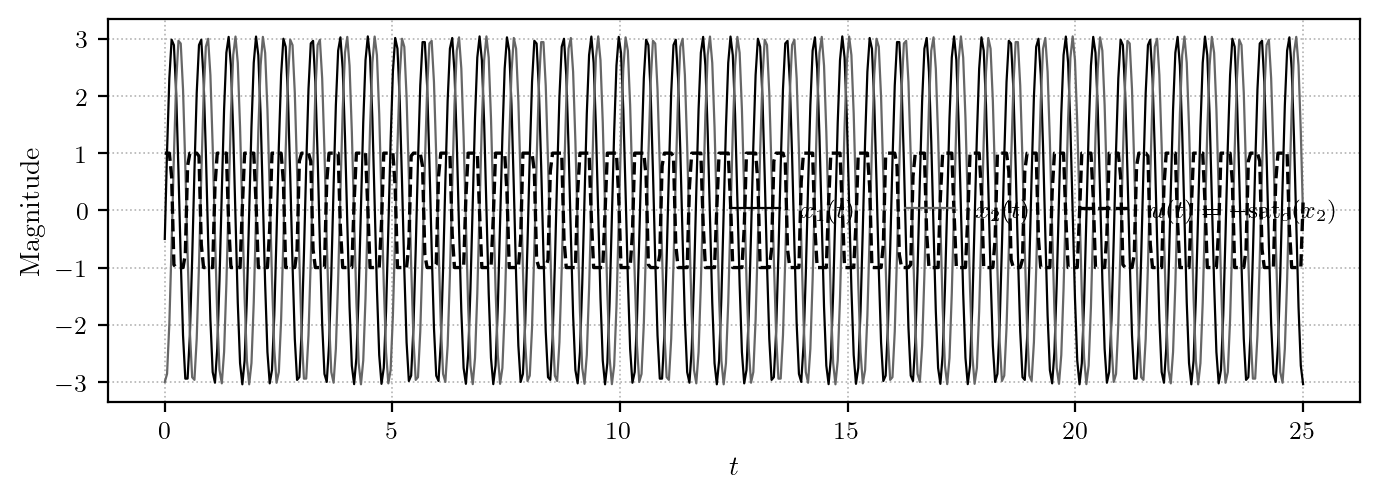

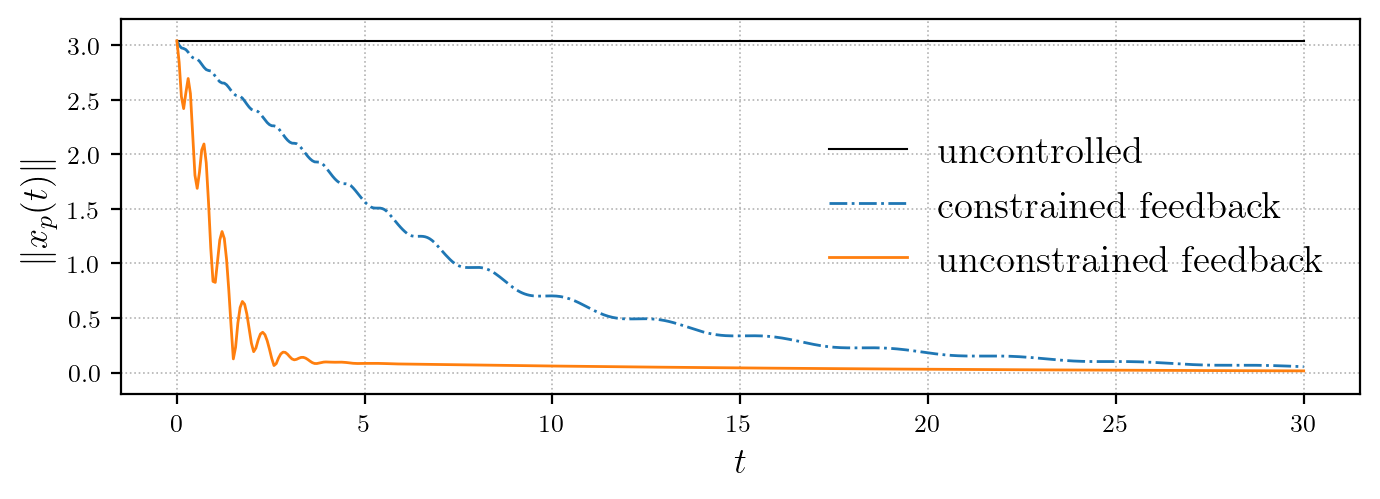

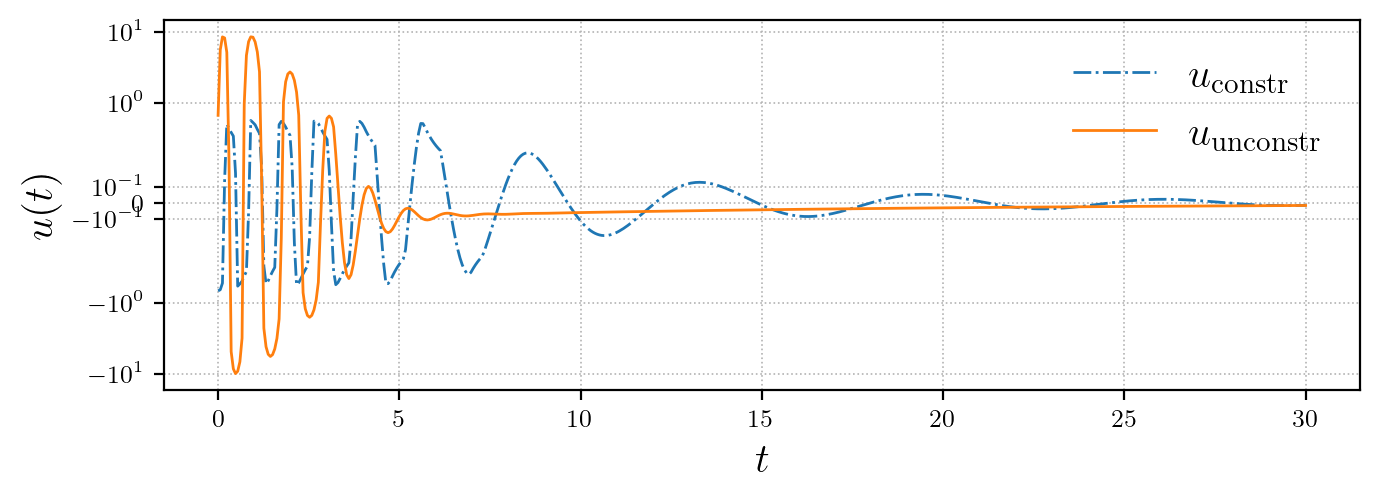

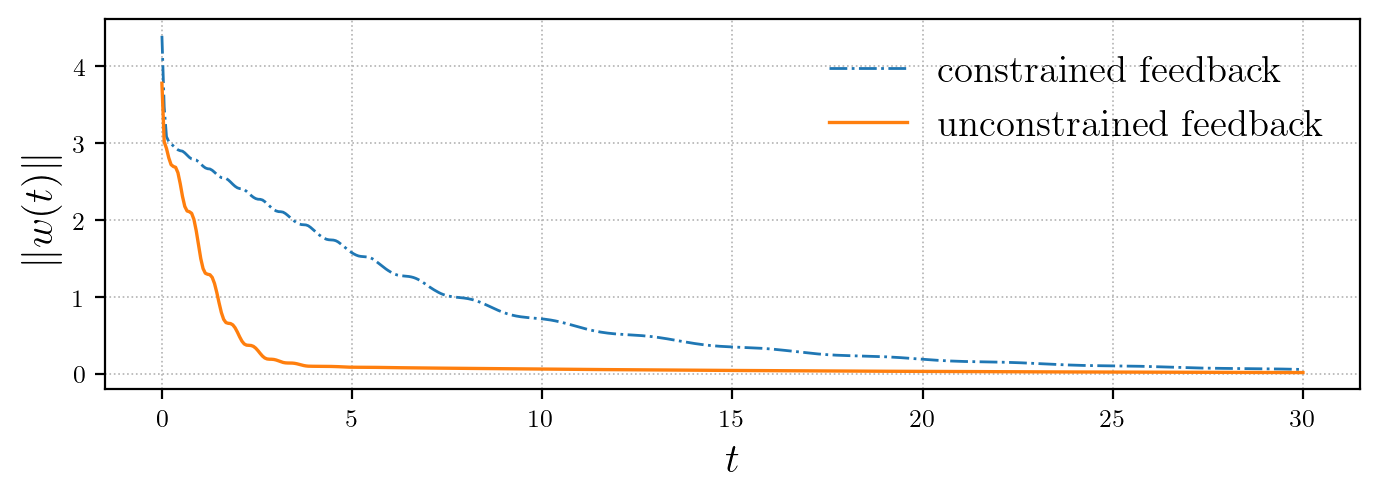

/Users/tillpreuster/full_norm.pdf

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from IPython.display import FileLink

# ------------------------------------------------------------------
# Journal-style defaults (LaTeX + serif + consistent sizing)
# ------------------------------------------------------------------
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    # --- IEEE / TAC font embedding ---
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# ------------------------------------------------------------------
# Conservative vector field
# ------------------------------------------------------------------
def w(r):
    return 1.0 + r**2

def f_conservative_ode(t, x):
    x1, x2 = x
    r = np.sqrt(x1**2 + x2**2)
    omega = w(r)
    return np.array([
        -omega * x2,
         omega * x1
    ])

# ------------------------------------------------------------------
# Simulation
# ------------------------------------------------------------------
t_span = (0.0, 25.0)
t_eval = np.linspace(*t_span, 500)
x0 = np.array([-0.5, -3.0])

sol = solve_ivp(
    f_conservative_ode,
    t_span,
    x0,
    t_eval=t_eval,
    rtol=1e-8,
    atol=1e-10
)

t = sol.t
x1, x2 = sol.y
norm_full = np.sqrt(x1**2 + x2**2)

# Saturation parameter
c = 1.0
u = -np.clip(x2, -c, c)

# Common y-limits
m = 0.2
y_max = np.max(norm_full)

# ==================================================================
# FIGURE 1: State trajectories and control
# ==================================================================
fig1, ax1 = plt.subplots(figsize=(7.0, 2.6))

ax1.plot(t, x1, linewidth=0.8, color="black", label=r"$x_1(t)$")
ax1.plot(t, x2, linewidth=0.8, color="0.4", label=r"$x_2(t)$")
ax1.plot(
    t, u,
    linestyle="--",
    linewidth=1.2,
    color="black",
    label=r"$u(t)=-\mathrm{sat}_c(x_2)$"
)

ax1.set_xlabel(r"$t$")
ax1.set_ylabel(r"Magnitude")
ax1.grid(True, linestyle=":", linewidth=0.6, color="0.7")
ax1.legend(frameon=False, ncols=3)
fig1.tight_layout()
plt.show()

# ==================================================================
# FIGURE 2: State norm comparison
# ==================================================================
fig2, ax2 = plt.subplots(figsize=(7.0, 2.6))

ax2.plot(
    times,
    norm_full[0] * np.ones_like(times),
    color="black",
    linestyle="-",
    linewidth=0.75,
    label="uncontrolled"
)

ax2.plot(
    times,
    np.linalg.norm(x_p_traj_constr, axis=0),
    color="tab:blue",
    linestyle="-.",
    linewidth=1.0,
    label="constrained feedback"
)

ax2.plot(
    times,
    np.linalg.norm(x_p_traj, axis=0),
    color="tab:orange",
    linestyle="-",
    linewidth=1.0,
    label="unconstrained feedback"
)

ax2.set_xlabel(r"$t$", fontsize=13)
ax2.set_ylabel(r"$\|x_p(t)\|$", fontsize=13)
ax2.set_ylim(-m, y_max + m)
ax2.grid(True, linestyle=":", linewidth=0.6, color="0.7")
ax2.legend(frameon=False, fontsize=14)
fig2.tight_layout()

# --- SAVE FIGURE 2 ---
fig2.savefig("state_norm_comparison.pdf", bbox_inches="tight")
fig2.savefig("state_norm_comparison.png", dpi=600, bbox_inches="tight")

plt.show()



# ==================================================================
# FIGURE 3: Control comparison
# ==================================================================
fig3, ax3 = plt.subplots(figsize=(7.0, 2.6))
#ax3.plot(
#    times,
#    0 * u_p_traj_new[0, :],
#    color="black",
#    linestyle="-",
#    linewidth=1.2,
#    label="uncontrolled"#r"$u \equiv 0$"
#)

ax3.plot(
    times,
    u_p_traj_new[0, :],
    color="tab:blue",
    linestyle="-.",
    linewidth=1.0,
    label=r"$u_{\mathrm{constr}}$"#r"$u=\mathrm{sat}_c$"
)

ax3.plot(
    times,
    u_p_traj[0, :],
    color="tab:orange",
    linestyle="-",
    linewidth=1.0,
    label=r"$u_{\mathrm{unconstr}}$"#r"$u=B^\top \lambda_0$"
)
ax3.set_xlabel(r"$t$",fontsize=15)
ax3.set_ylabel(r"$u(t)$", fontsize=15)
#ax3.set_ylim(-1.3, 1.3)
ax3.set_yscale(
    "symlog",
    linthresh=0.5,     # width of linear region around 0
    linscale=1.0
)
ax3.grid(True, linestyle=":", linewidth=0.6, color="0.7")
ax3.legend(frameon=False, fontsize=15)
fig3.tight_layout()

# --- SAVE FIGURE 3 ---
fig3.savefig("control_comparison.pdf", bbox_inches="tight")
fig3.savefig("control_comparison.png", dpi=600, bbox_inches="tight")

plt.show()

# ------------------------------------------------------------------
# Clickable download links (appear in notebook output)
# ------------------------------------------------------------------


# ==================================================================
# FIGURE 3: Control comparison
# ==================================================================
fig4, ax4 = plt.subplots(figsize=(7.0, 2.6))


ax4.plot(
    times,
    norm_delta_new,
    color="tab:blue",
    linestyle="-.",
    linewidth=1.0,
    label="constrained feedback"#r"$u=\mathrm{sat}_c$"
)
ax4.plot(
    times,
    norm_delta,
    color="tab:orange",
    linestyle="-",
    linewidth=1.2,
    label="unconstrained feedback"#r"$u \equiv 0$"
)

ax4.set_xlabel(r"$t$",fontsize=15)
ax4.set_ylabel(r"$\|w(t) \|$", fontsize=15)
#ax4.set_ylim(-1.3, 1.3)
ax4.grid(True, linestyle=":", linewidth=0.6, color="0.7")
ax4.legend(frameon=False, fontsize=14)
fig4.tight_layout()


fig4.savefig("full_norm.pdf", bbox_inches="tight")
fig4.savefig("full_norm.png", dpi=600, bbox_inches="tight")

plt.show()

FileLink("state_norm_comparison.pdf")

#FileLink("control_comparison.pdf")

FileLink("full_norm.pdf")


